In [1]:
import sys 
sys.path.append('../../RenderMan/Builds/LinuxMakefile/build/')
sys.path.append('../../dexed/Builds/Linux/build/')


In [2]:
import librenderman as rm
import numpy as np
import scipy.optimize as optimize
from IPython.display import Audio

In [3]:
# Important settings. These are good general ones.
sampleRate = 44100
bufferSize = 512
fftSize = 512

# This will host a VST. It will render the features and audio we need.
engine = rm.RenderEngine(sampleRate, bufferSize, fftSize)

# Load the VST into the RenderEngine.
path = "../../dexed/Builds/Linux/build/Dexed.so"
path = "../../amsynth-1.8.0/.libs/amsynth_vst.so"
engine.load_plugin(path)

# Create a patch generator. We can initialise it to generate the correct
# patches for a given synth by passing it a RenderEngine which has
# loaded a instance of the synthesiser. 
generator = rm.PatchGenerator(engine)

# We can also get a string of information about the
# available parameters.
#print engine.get_plugin_parameters_description()
paramsDict = engine.get_plugin_parameters_description()
paramsDict = {p.split(':')[1].strip():int(p.split(':')[0].strip()) for p in paramsDict.split('\n')[:-1]}
print paramsDict

{'filter_vel_sens': 38, 'amp_decay': 1, 'osc2_range': 17, 'filter_kbd_track': 37, 'filter_env_amount': 10, 'amp_release': 3, 'lfo_waveform': 16, 'filter_sustain': 7, 'filter_mod_amount': 20, 'portamento_time': 31, 'filter_cutoff': 11, 'portamento_mode': 40, 'reverb_damp': 26, 'osc2_detune': 12, 'osc_mix': 18, 'osc2_pulsewidth': 24, 'lfo_freq': 15, 'osc_mix_mode': 22, 'filter_slope': 35, 'distortion_crunch': 29, 'osc1_pulsewidth': 23, 'amp_sustain': 2, 'osc2_pitch': 33, 'keyboard_mode': 32, 'filter_type': 34, 'freq_mod_amount': 19, 'reverb_width': 28, 'freq_mod_osc': 36, 'filter_release': 8, 'reverb_roomsize': 25, 'master_vol': 14, 'osc1_waveform': 4, 'reverb_wet': 27, 'amp_mod_amount': 21, 'osc2_waveform': 13, 'amp_attack': 0, 'amp_vel_sens': 39, 'filter_resonance': 9, 'filter_attack': 5, 'filter_decay': 6, 'osc2_sync': 30}


In [51]:
# Settings to play a note and extract data from the synth.
midiNote = 80
midiVelocity = 127
noteLength = 0.1
renderLength = 0.1

fixedParams={'filter_vel_sens': 0, 'amp_decay': 0, 'osc2_range': 0,
             'filter_kbd_track': 0, 'filter_env_amount': 1, 'amp_release': 0,
             'lfo_waveform': 0, 'filter_sustain': 1, 'filter_mod_amount': 1,
             'portamento_time': 1, 'filter_cutoff': 0, 'portamento_mode': 1,
             'reverb_damp': 0, 'osc2_detune': 0, 'osc_mix': 0.5, 'osc2_pulsewidth': 0,
             'lfo_freq': 0, 'osc_mix_mode': 1, 'filter_slope': 1, 'distortion_crunch': 0,
             'osc1_pulsewidth': 0, 'amp_sustain': 1, 'osc2_pitch': 0, 'keyboard_mode': 1,
             'filter_type': 0, 'freq_mod_amount': 0, 'reverb_width': 0, 'freq_mod_osc': 0,
             'filter_release': 0, 'reverb_roomsize': 0, 'master_vol': 1, 'osc1_waveform': 0,
             'reverb_wet': 0, 'amp_mod_amount': 0, 'osc2_waveform': 0, 'amp_attack': 0,
             'amp_vel_sens': 0, 'filter_resonance': 0, 'filter_attack': 0,
             'filter_decay': 0, 'osc2_sync': 0}

dynParams=['osc_mix','osc2_pitch','osc2_range','filter_cutoff','osc1_waveform','osc2_waveform','filter_resonance','osc2_sync']


def wrapSynth(xParams, getAudio=False):
    
    for key,value in fixedParams.items():
        engine.override_plugin_parameter(paramsDict[key], value)
        
    for key,value in zip(dynParams,xParams):
        engine.override_plugin_parameter(paramsDict[key], value)
    
    engine.render_patch(midiNote, midiVelocity, noteLength, renderLength)

    # Get the data. Note the audio is automattically made mono, no
    # matter what channel size for ease of use.
    if getAudio:
        audio = engine.get_audio_frames()
        return audio
    
    mfccs = np.mean(engine.get_mfcc_frames(),axis=0)
    return mfccs



In [70]:
np.random.seed(100)
tParams = np.random.uniform(size=len(dynParams))
print(tParams)
target = wrapSynth(tParams, getAudio=True)
targetMfccs = wrapSynth(tParams, getAudio=False)
Audio(target, rate=sampleRate)


[0.54340494 0.27836939 0.42451759 0.84477613 0.00471886 0.12156912
 0.67074908 0.82585276]


In [71]:
def metric(xParams):
    test = wrapSynth(xParams)
    return np.linalg.norm(test-targetMfccs)

bounds = [(0,1) for p in range(len(dynParams))]
popt = optimize.differential_evolution(metric,bounds,mutation=(1.0,1.2), workers=-1,maxiter=5, disp=True)

differential_evolution step 1: f(x)= 0.288176
differential_evolution step 2: f(x)= 0.288176
differential_evolution step 3: f(x)= 0.288176
differential_evolution step 4: f(x)= 0.288176
differential_evolution step 5: f(x)= 0.249037


In [73]:
print popt.x
audio = wrapSynth(popt.x, getAudio=True)
audioMfccs = wrapSynth(popt.x, getAudio=False)
Audio(audio, rate=sampleRate, autoplay=True)

[0.70664012 0.89651828 0.15659007 0.99206688 0.05119154 0.62186262
 0.6789035  0.7124158 ]


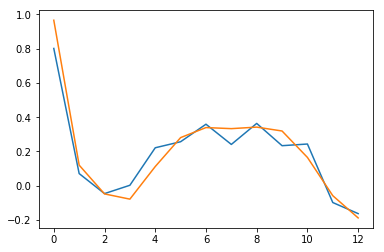

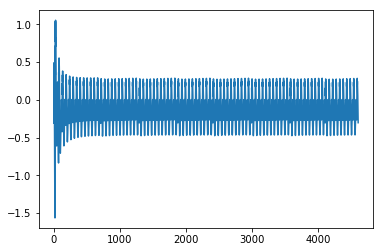

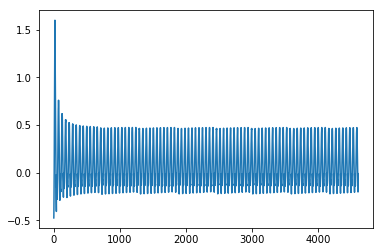

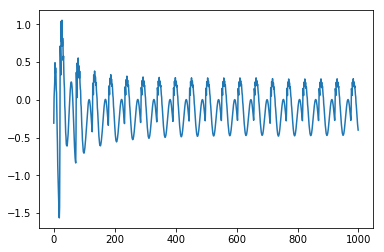

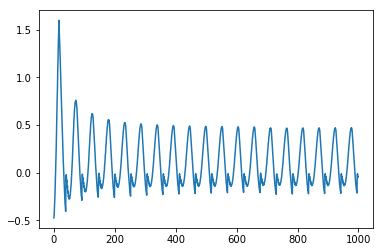

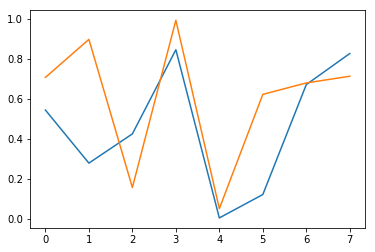

In [74]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.plot(np.array(targetMfccs))
plt.plot(np.array(audioMfccs))
plt.show()

plt.plot(target)
plt.show()
plt.plot(audio)
plt.show()

plt.plot(target[:1000])
plt.show()
plt.plot(audio[:1000])
plt.show()

plt.plot(tParams)
plt.plot(popt.x)
plt.show()

Audio(target, rate=sampleRate,autoplay=True)


In [59]:
Audio(audio, rate=sampleRate, autoplay=True)